In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib import slim

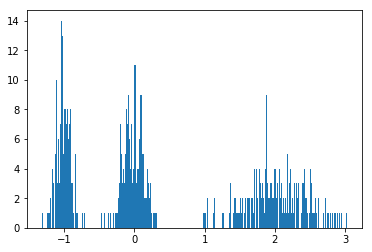

In [5]:
# first, sample from a fixed mixture distribution with gumbel-softmax
# this is the target distribution
# this also partly illustrates how we will structure our generator

mixture_components = np.array([.3,.3,.4],dtype=np.float32)
n_components = 3
tau = .001
batch_size = 500

mixture_means = np.array([-1,0.,2],dtype=np.float32)
mixture_sds = np.array([.1,.15,.4],dtype=np.float32)

x = tf.random_uniform((batch_size,n_components),dtype=tf.float32)
eps = tf.random_normal((batch_size,1),dtype=tf.float32)

def softmax(e,axis=1):
    f = tf.exp(e - tf.expand_dims(tf.reduce_max(e,axis=axis),axis=axis))
    return f / tf.expand_dims(tf.reduce_sum(f,axis=axis),axis=axis)

def gumbel_softmax(x,pi,tau): 
    g = -tf.log(-tf.log(x))
    f = (tf.log(pi)[tf.newaxis,:] + g) / tau
    return softmax(f,axis=1)

g = gumbel_softmax(x,mixture_components,tau)

y = tf.reduce_sum(g * mixture_means[tf.newaxis,:], axis=1)[:,tf.newaxis] + tf.reduce_sum(g * mixture_sds[tf.newaxis,:],axis=1)[:,tf.newaxis] * eps

with tf.Session() as s:
    y_ = s.run(y)

plt.hist(y_[~np.isnan(y_)],300)
plt.show()

In [6]:
# corrected softmax to avoid nan by first subtracting the max

np.sum(np.isnan(y_))/len(y_)

0.0

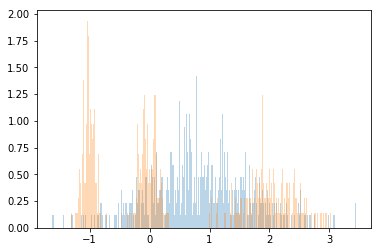

In [7]:
# next, sample from a gaussian with similar coverage

mu_ref = .8
sd_ref = .8

ref = tf.random_normal((batch_size,1),dtype=tf.float32)*sd_ref + mu_ref

with tf.Session() as s:
    ref_ = s.run(ref)
    
plt.hist(ref_,300,alpha=.3,normed=True)
plt.hist(y_[~np.isnan(y_)],300,alpha=.3,normed=True)
plt.show()

In [8]:
def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

def adversary(y, reuse=False):
    with tf.variable_scope("adversary", reuse=reuse) as scope:
        with slim.arg_scope([slim.fully_connected], activation_fn=lrelu):
            net = slim.fully_connected(y, 256, scope='fc_0')

            for i in range(5):
                dnet = slim.fully_connected(net, 256, scope='fc_%d_r0' % (i+1))
                net += slim.fully_connected(dnet, 256, activation_fn=None, scope='fc_%d_r1' % (i+1),
                                            weights_initializer=tf.constant_initializer(0.))
                net = lrelu(net) 

        T = slim.fully_connected(net, 1, activation_fn=None, scope='T',
                                weights_initializer=tf.constant_initializer(0.))
        T = tf.squeeze(T, [1])
        return T

def sampler(reuse=False): # gumbel-softmax sampler
    z = None
    return z

def reference(reuse=False): # reference distribution sampler
    z = None
    return z
    
def posterior(reuse=False): # unnormalized distribution used for training
    with tf.variable_scope("posterior", reuse=reuse) as scope:
        # eps = standard_normal([batch_size, param_dim]).value()
        
        Normal = tf.distributions.Normal(loc=tf.zeros(param_dim), scale=tf.ones(param_dim))
        eps = Normal.sample([batch_size])
        
        with slim.arg_scope([slim.fully_connected], activation_fn=tf.nn.elu):
            net = slim.fully_connected(eps, 128, scope='fc_0')
            net = slim.fully_connected(net, 128, scope='fc_1')
#             net = slim.fully_connected(net, 128, scope='fc_2')
                
        z = slim.fully_connected(net, param_dim, activation_fn=tf.nn.tanh, scope='z')
        return z

In [9]:
# next, discriminate between this distribution and a gaussian reference distribution

lr = 1e-4
n_steps = 500

dref = adversary(ref)
dy = adversary(y,reuse=True)

dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "adversary")

dloss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=dy, labels=tf.ones_like(dy))
    + tf.nn.sigmoid_cross_entropy_with_logits(logits=dref, labels=tf.zeros_like(dref))
)

train_step = tf.train.AdamOptimizer(lr).minimize(dloss,var_list=dvars)

In [10]:
from tqdm import tqdm_notebook, tnrange

def run_training(sess, niter=10000):       

    progress = tqdm_notebook(range(niter))

    for i in progress:
              
        y_,ref_,dref_,dy_,dloss_,_ = s.run([y,ref,dref,dy,dloss,train_step])
            
        progress.set_description("loss=%.3f"  % (dloss_))
        
        if i%500 == 0:
            fig,ax=plt.subplots(1,2,figsize=(10,5))
            ax[0].scatter(y_,dy_,alpha=.3)
            ax[0].scatter(ref_,dref_,alpha=.3)
            ax[1].hist(y_,50)
            ax[1].hist(ref_,50)
            plt.savefig('out_like/iter_%i.png' % i)

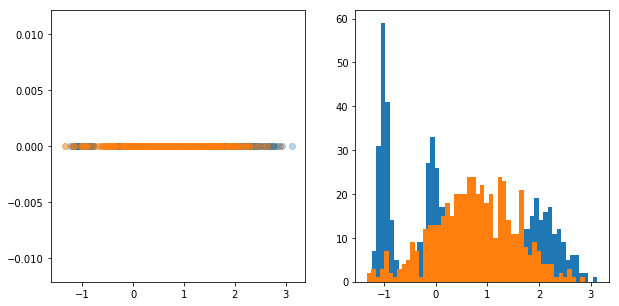

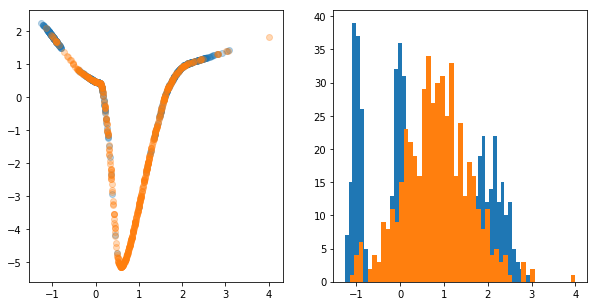

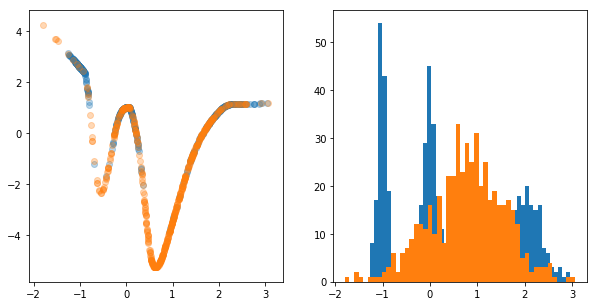

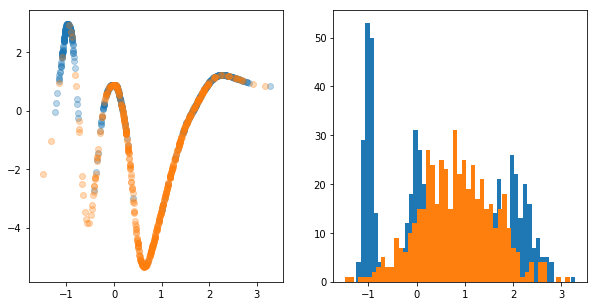

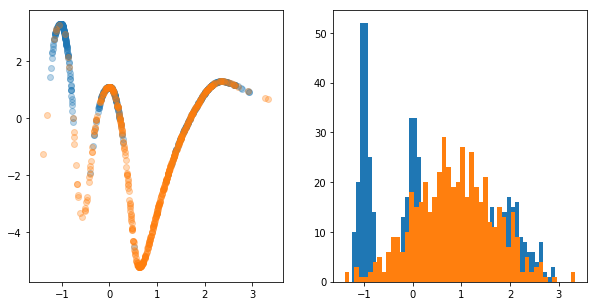

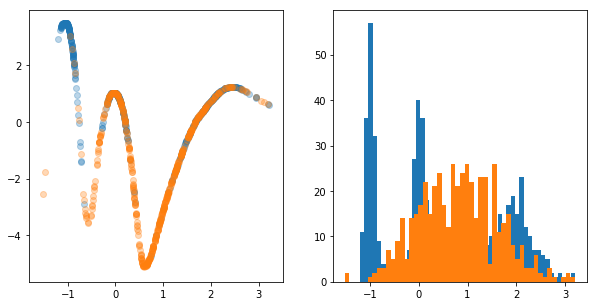

In [12]:
import os
outdir = './out_like'
if not os.path.exists(outdir):
    os.makedirs(outdir)

try:
    s.close()
except NameError:
    pass
s = tf.InteractiveSession()
s.run(tf.global_variables_initializer())
run_training(s,niter=3000)